# Multilevel Slopes
+ other features

In [22]:
import pystan
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import arviz as az

%matplotlib inline

# Train/Test data
train = pd.read_csv('../data/raw/train.csv').assign(data_type = 'train')
test = pd.read_csv('../data/raw/test.csv').assign(data_type = 'test')

# Want to ensure the encodings of the neighbourhoods as indexes are consistent
df_full = train.append(test, ignore_index = True)
df_full['neighbourhood'] = df_full['Neighborhood'].astype('category').cat.codes+1

# Log variables
df_full['log_sales_price'] = np.log(df_full['SalePrice'])
df_full['log_lot_area'] = np.log(df_full['LotArea'])

# Train/test split
train = df_full.loc[df_full['data_type'] == 'train'].copy()
test = df_full.loc[df_full['data_type'] == 'test'].copy()

# Center and scale predictor (train)
train['log_lot_area_z'] = (train[['log_lot_area']] - train[['log_lot_area']].mean()) / train[['log_lot_area']].std()

# Scale target (train)
train['log_sales_price_std'] = train['log_sales_price']/train['log_sales_price'].mean()

# Center and scale predictor using training data mean and std
test['log_lot_area_z'] = (test[['log_lot_area']] - train[['log_lot_area']].mean()) / train[['log_lot_area']].std()

# Scale target using training data mean
test['log_sales_price_std'] = test['log_sales_price']/train['log_sales_price'].mean()

In [23]:
def standardise_predictor(column):
    '''
    Standardise variable to mean zero and standard deviation one
    '''
    std_pred_train = (train[['{}'.format(column)]] - train[['{}'.format(column)]].mean()) / train[['{}'.format(column)]].std()
    std_pred_test = (test[['{}'.format(column)]] - train[['{}'.format(column)]].mean()) / train[['{}'.format(column)]].std()
    
    return std_pred_train, std_pred_test


In [32]:
# Standardise predictor variables
column_list = ['BedroomAbvGr', 
               'OverallCond', 
               'OverallQual',
               'GrLivArea',
               '1stFlrSF',
               '2ndFlrSF']

for idx, col in enumerate(column_list):
    
    std_pred_train, std_pred_test = standardise_predictor(col)
    
    if idx == 0:
        X = std_pred_train
        X_test = std_pred_test
    else:
        X = pd.concat([X, std_pred_train], axis = 1)
        X_test = pd.concat([X_test, std_pred_test], axis = 1)

In [30]:
# Import multilevel model
multilevel_slopes = pystan.StanModel(file = '../src/models/multilevel_slopes_extra.stan')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_ea00aaf775a98ddbea8062df242a0860 NOW.


In [ ]:
data_check = dict(N = len(train),
                  N_test = len(test),
                  P = len(X.columns),
                  P_test = len(X_test.columns),
                  X = X,
                  X_test = X_test,
                  log_sales_price = train['log_sales_price_std'],
                  neighbourhood = train['neighbourhood'],
                  N_neighbourhood = len(train['Neighborhood'].unique()),
                  neighbourhood_test = test['neighbourhood'],
                  log_lot_area = train['log_lot_area_z'],
                  log_lot_area_test = test['log_lot_area_z'],
                  run_estimation = 0)

fit_model_check = multilevel_slopes.sampling(data=data_check)
df_model_check = fit_model_check.to_dataframe()

## Prior predcitive checks

In [48]:
import arviz as az
%config InlineBackend.figure_format = 'retina'
az.style.use('arviz-darkgrid')

fit_model_check.filter(regex = 'y_hat').T.iloc[:, :100].plot.kde(alpha=0.3,
                                                        legend = False, 
                                                        xlim = (-10, 10));

AttributeError: 'stanfit4anon_model_0e5d8e8d29bd46283fde90c526d9a5c' object has no attribute 'filter'

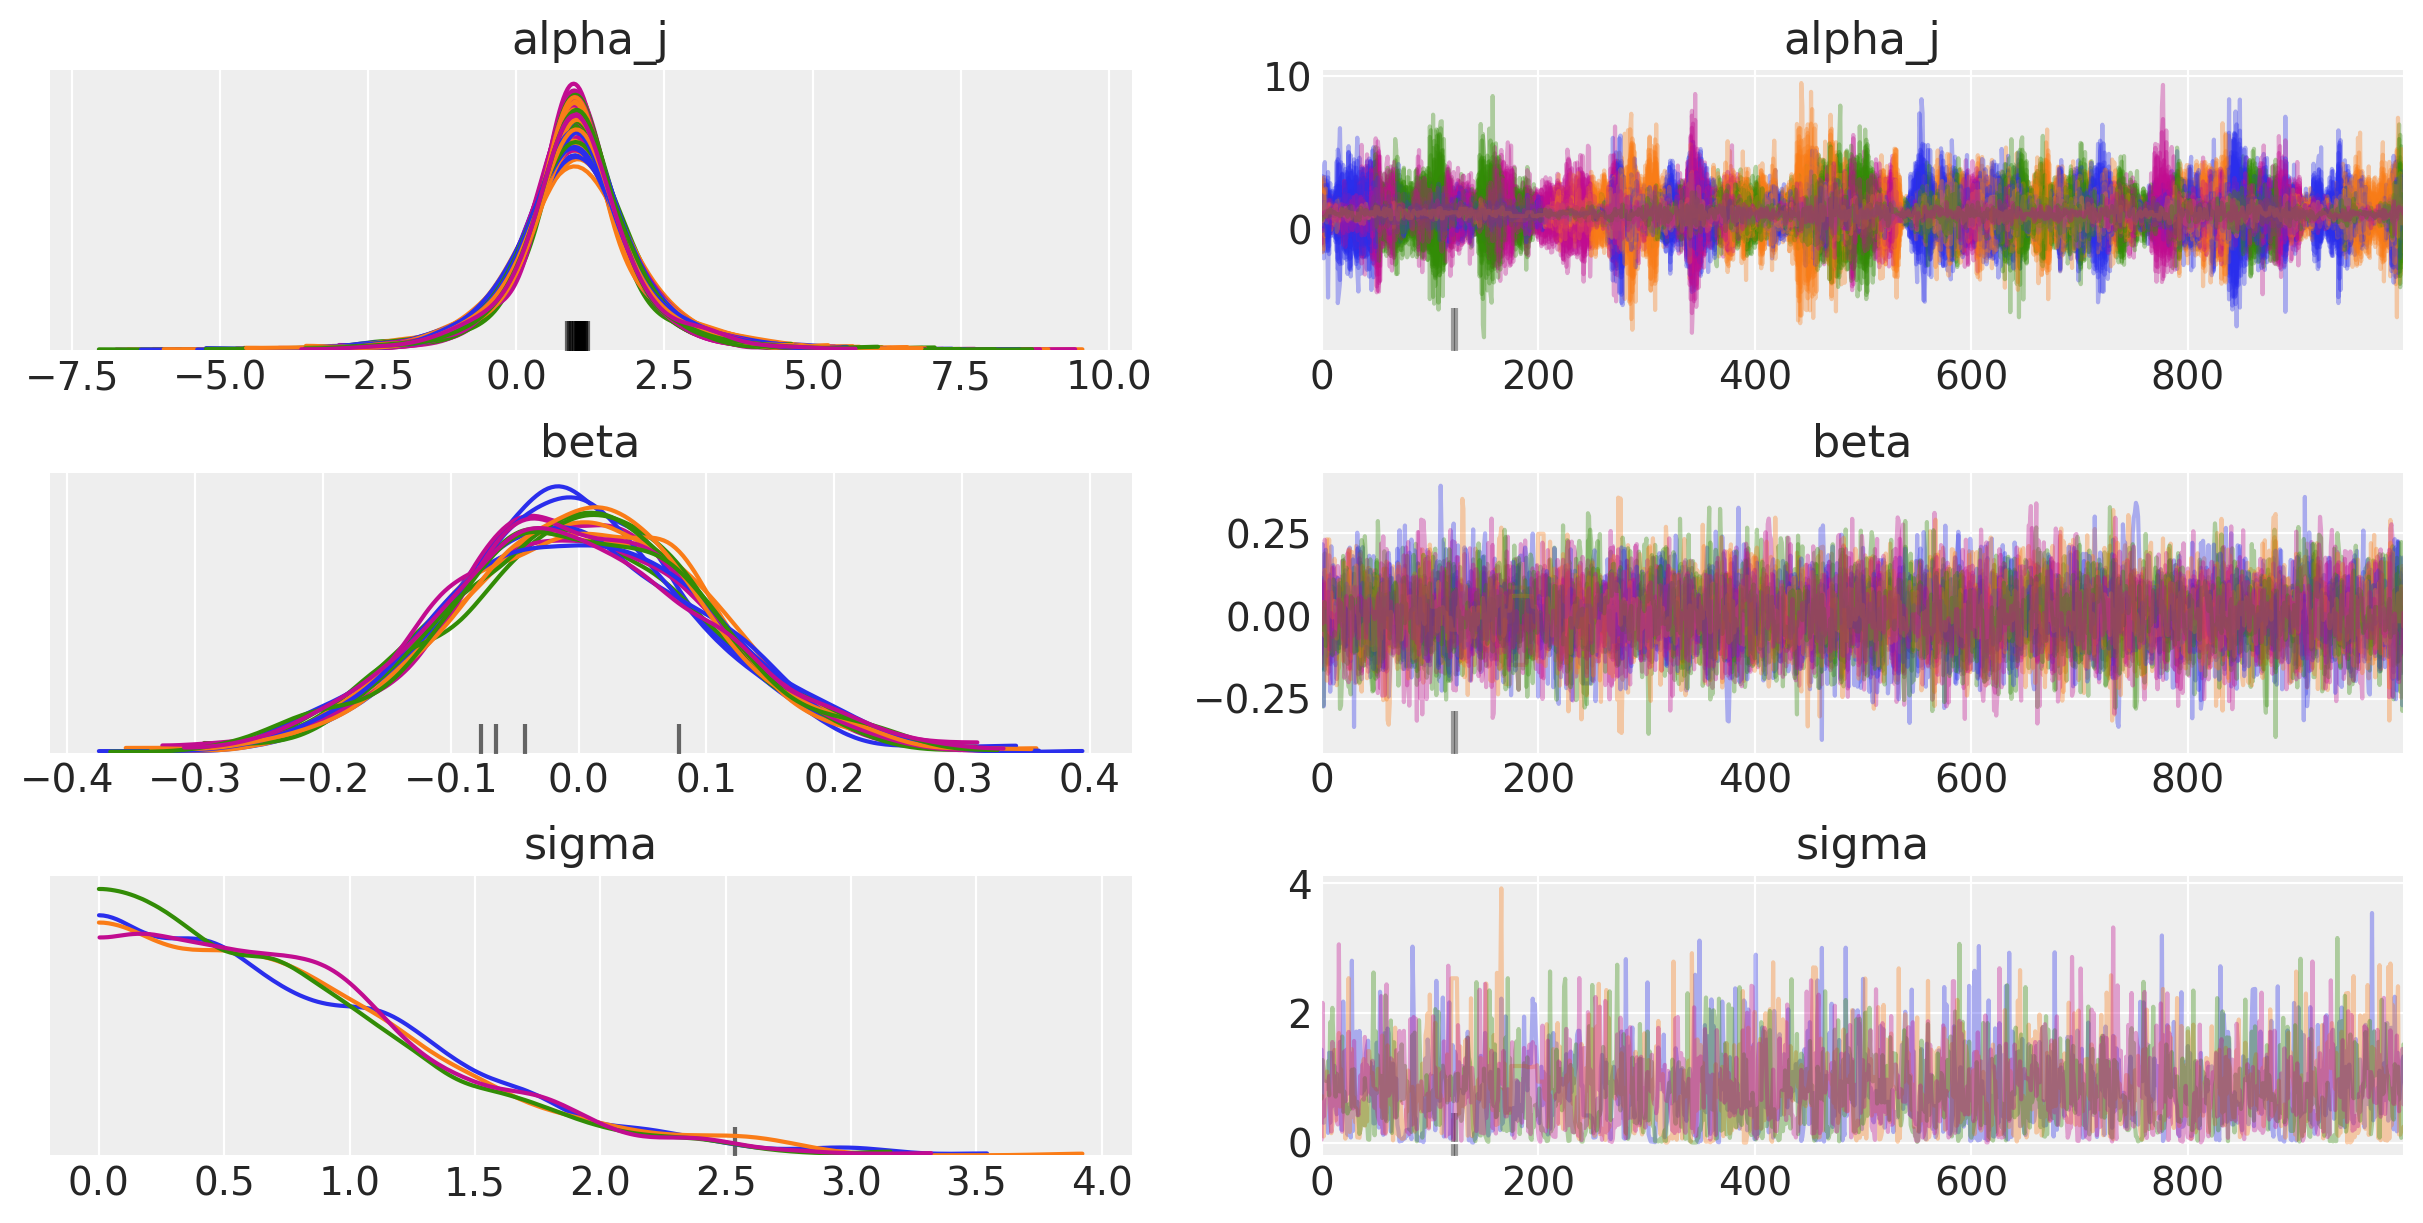

In [49]:
az.plot_trace(fit_model_check, var_names=["alpha_j", "beta", "sigma"], compact = True);

In [ ]:
## Fit model on fake data and recapture known parameters (appendix?)

In [ ]:
## Fit model on real data

In [33]:
data = dict(N = len(train),
            N_test = len(test),
            P = len(X.columns),
            P_test = len(X_test.columns),
            X = X,
            X_test = X_test,
            log_sales_price = train['log_sales_price_std'],
            neighbourhood = train['neighbourhood'],
            N_neighbourhood = len(train['Neighborhood'].unique()),
            neighbourhood_test = test['neighbourhood'],
            log_lot_area = train['log_lot_area_z'],
            log_lot_area_test = test['log_lot_area_z'],
            run_estimation = 1)

fit_model = multilevel_slopes.sampling(data=data, n_jobs = 4)
df_model = fit_model.to_dataframe()

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


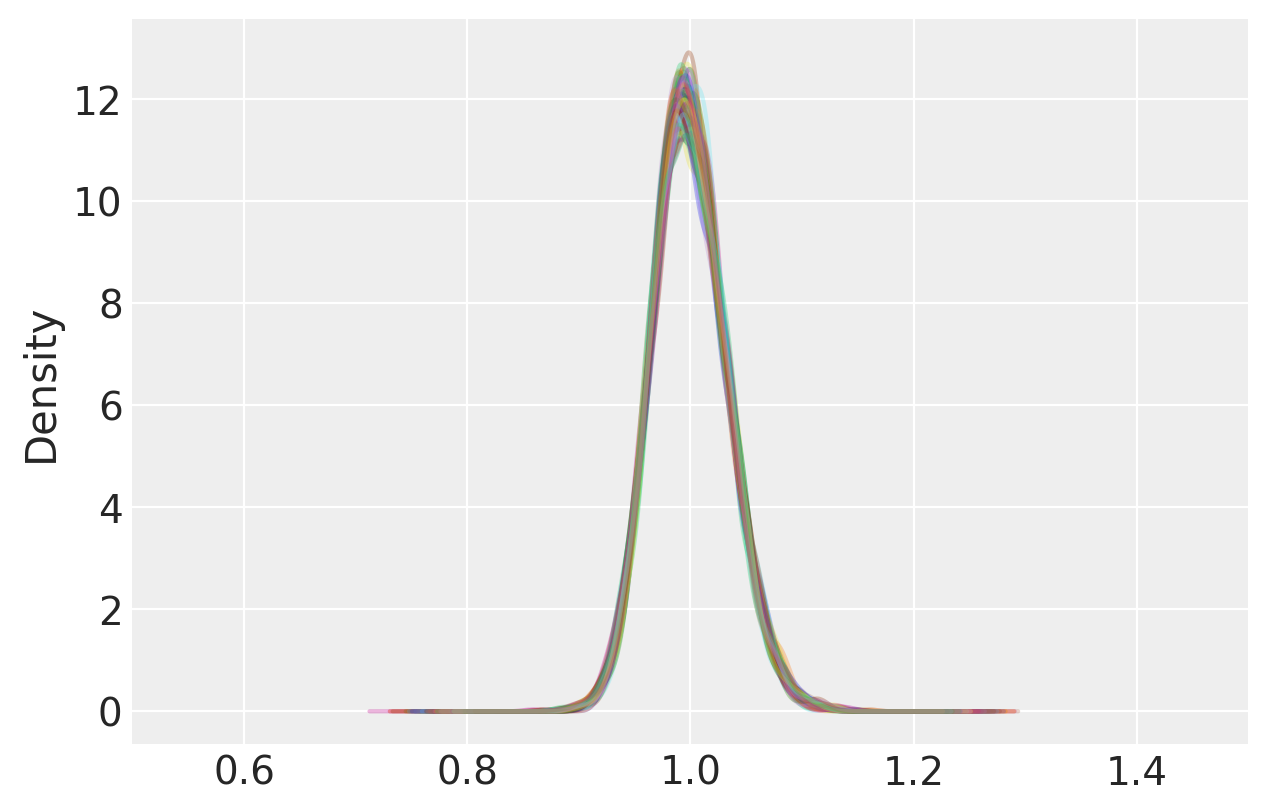

In [34]:
import arviz as az
%config InlineBackend.figure_format = 'retina'
az.style.use('arviz-darkgrid')

df_model.filter(regex = 'y_hat').T.iloc[:, :100].plot.kde(alpha=0.3,
                                                        legend = False, 
                                                        xlim = (.5, 1.5));

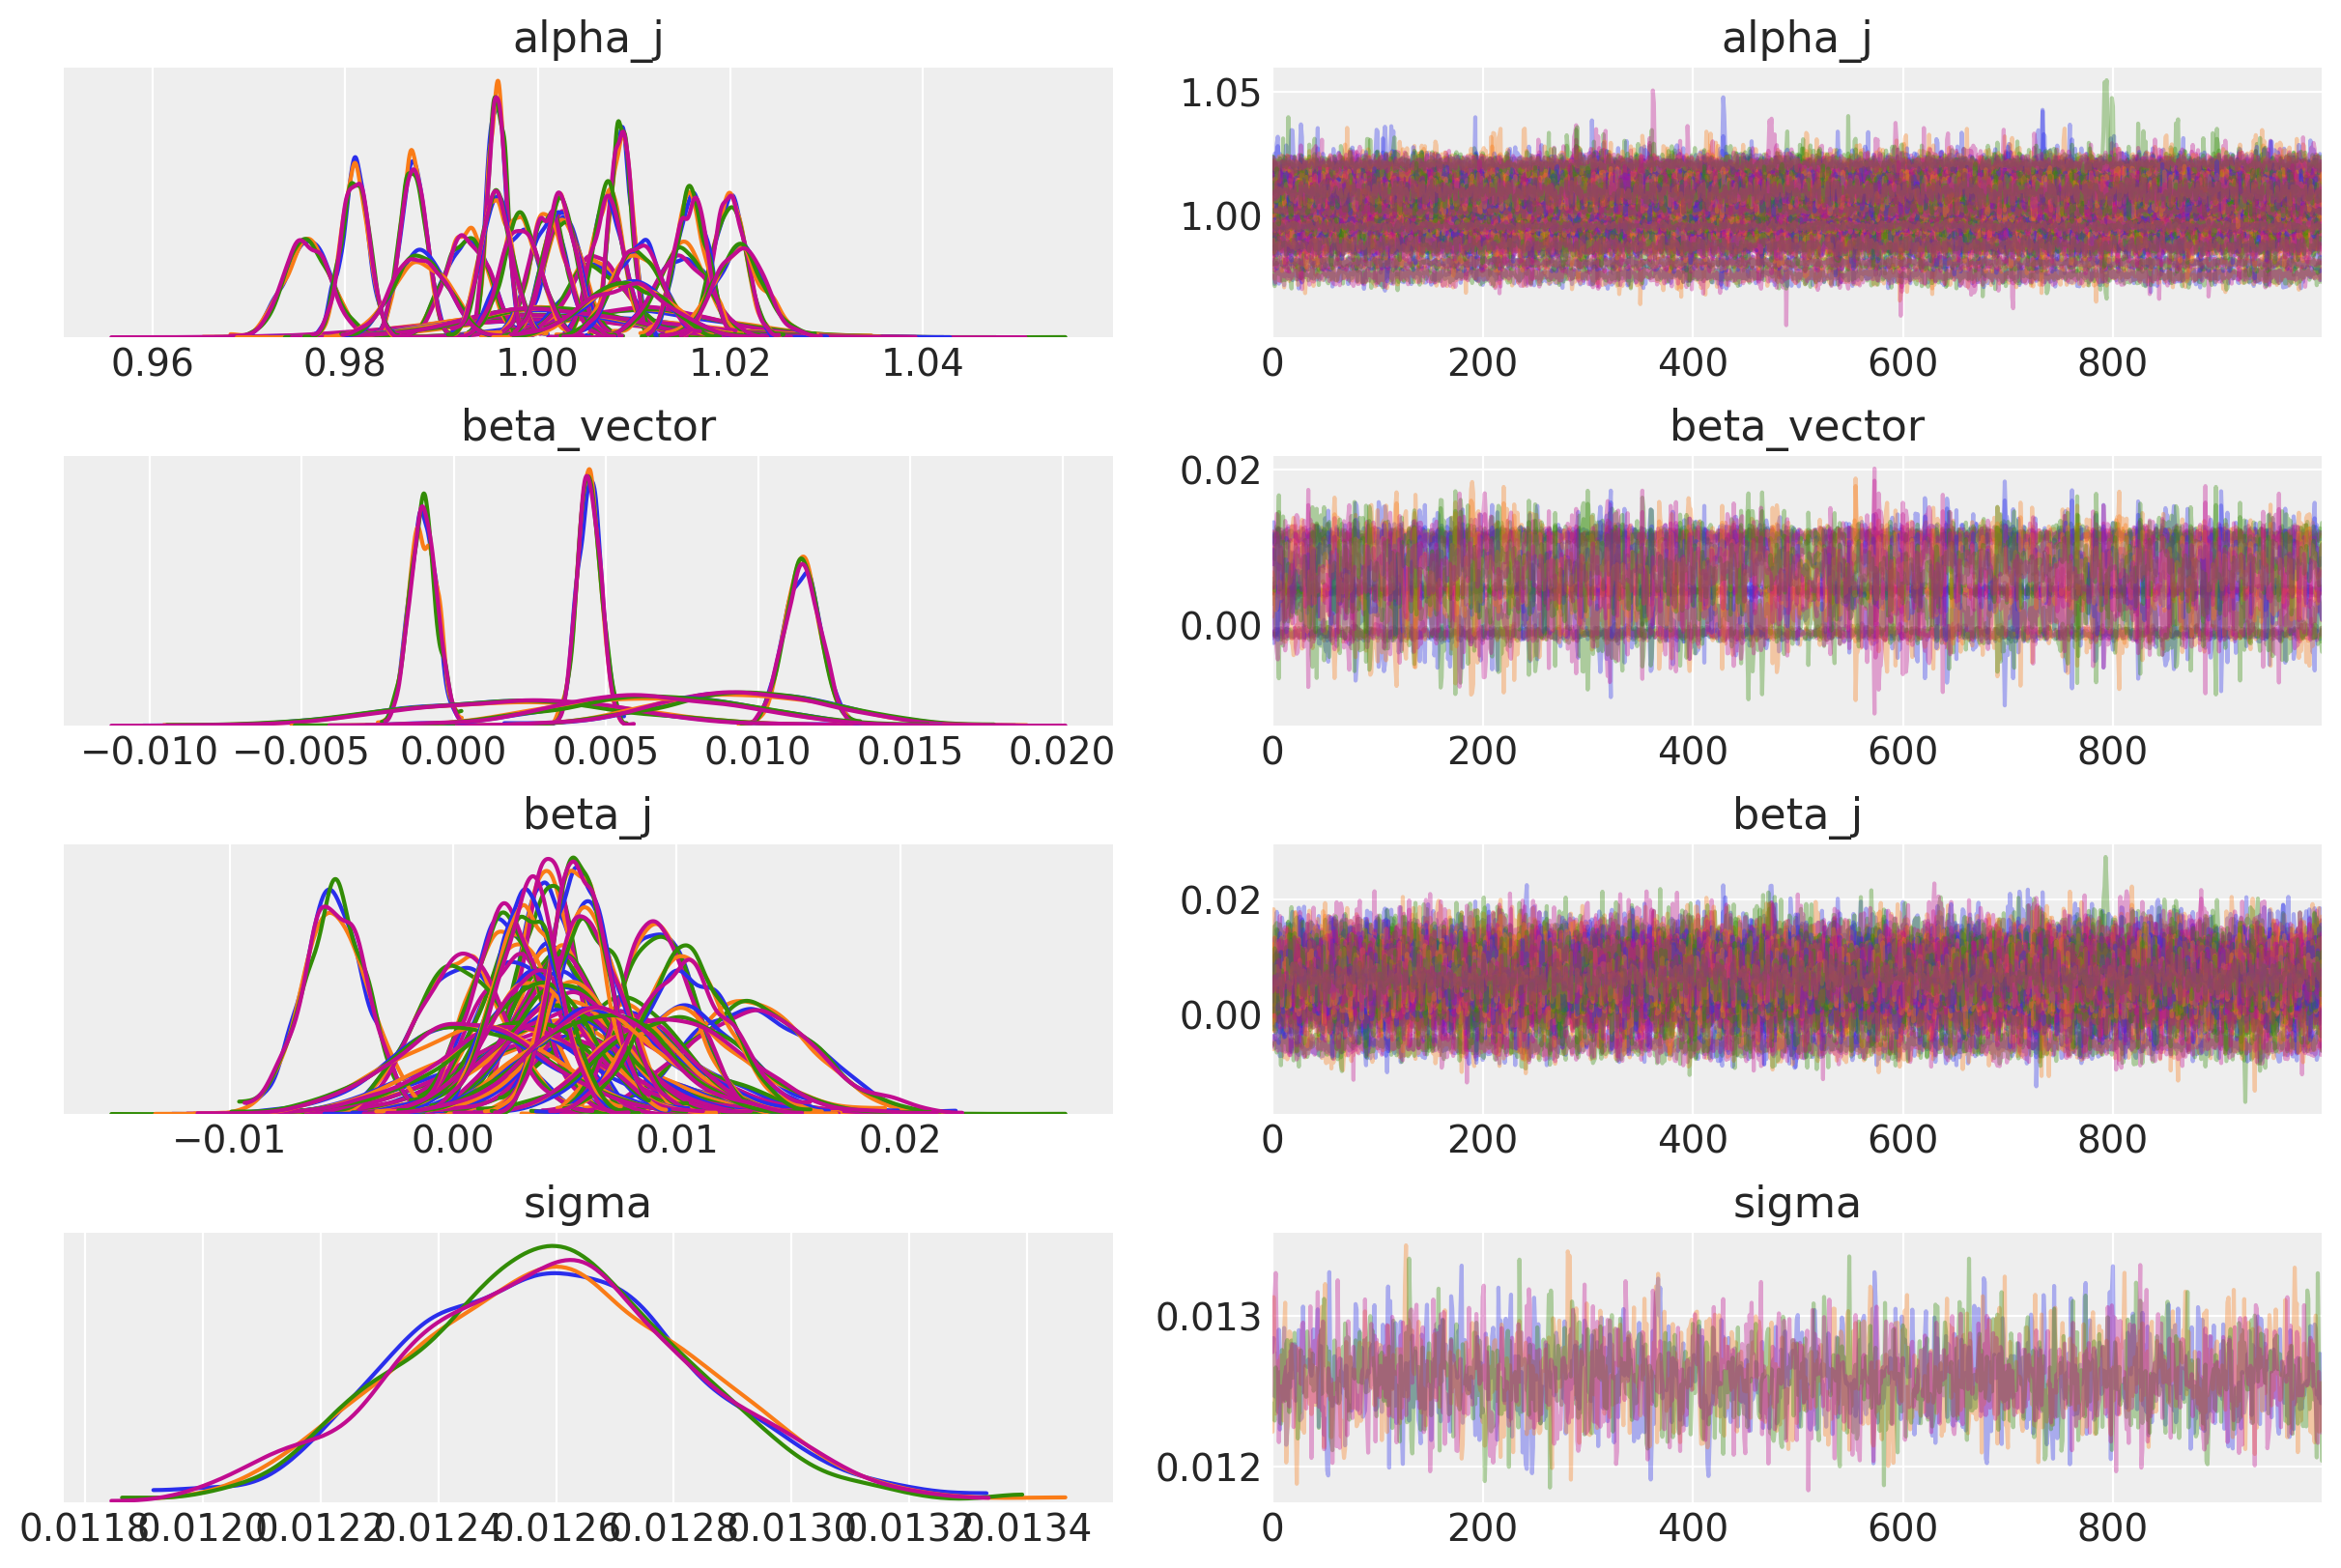

In [35]:
az.plot_trace(fit_model, var_names=["alpha_j", 'beta_vector', 'beta_j', "sigma"], compact = True);

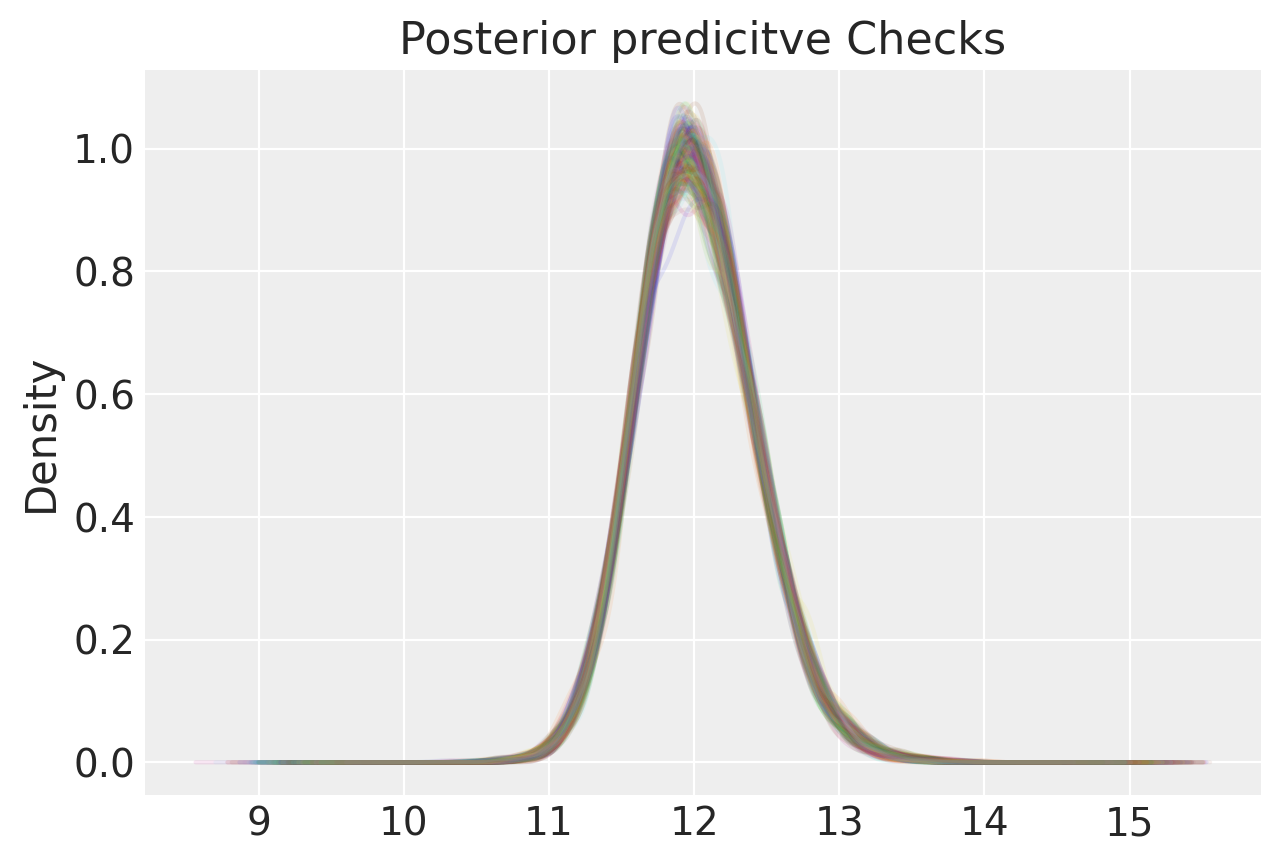

In [49]:
fig, axes = plt.subplots(1,1)
(df_model.filter(regex = 'y_hat')*train['log_sales_price'].mean()).T.iloc[:, :300].plot.kde(legend = False, 
                                                                                                  title = 'Posterior predicitve Checks', 
#                                                                                                  xlim = (-2,2),
                                                                                                  alpha = 0.1,
                                                                                                  ax = axes);

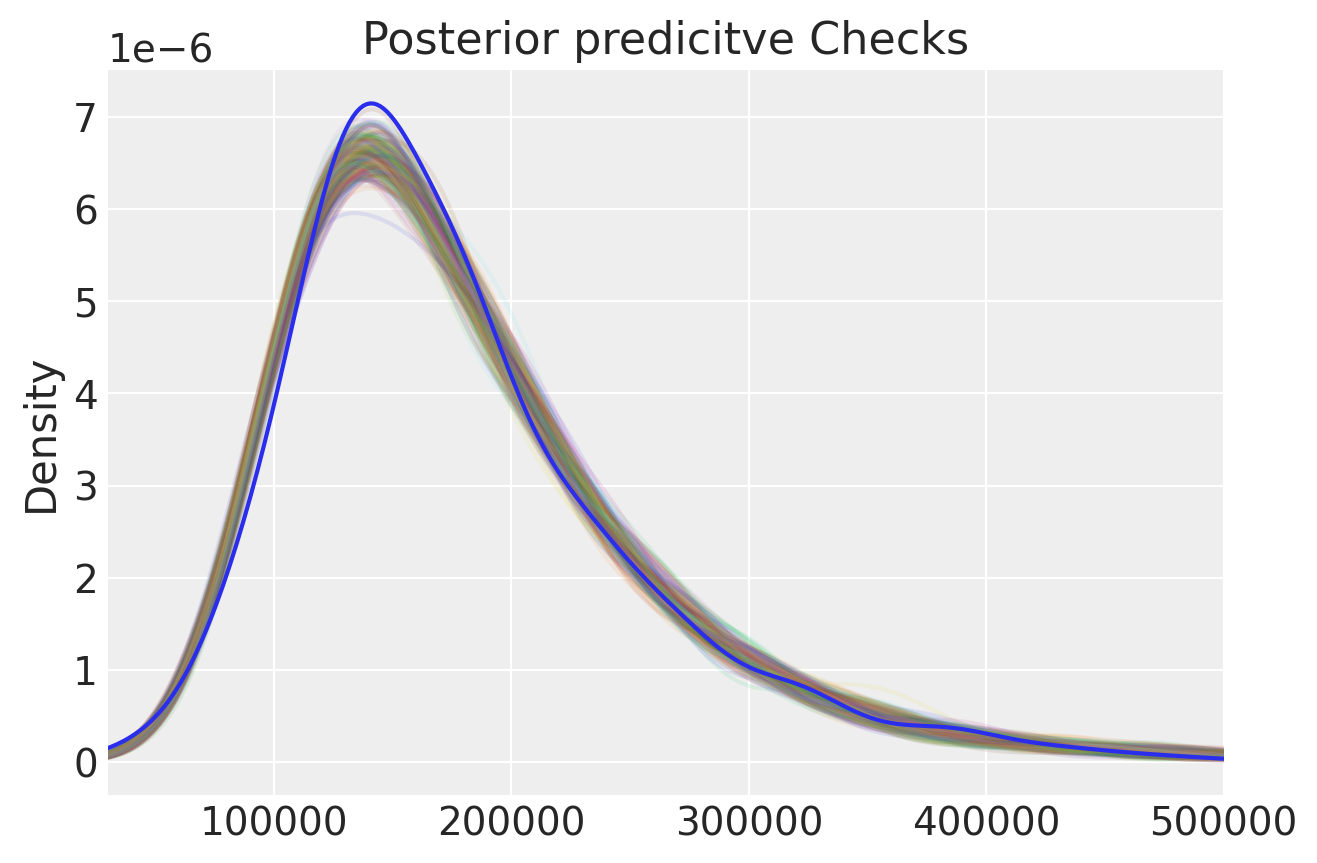

In [36]:
fig, axes = plt.subplots(1,1)
np.exp(df_model.filter(regex = 'y_hat')*train['log_sales_price'].mean()).T.iloc[:, :300].plot.kde(legend = False, 
                                                                                                  title = 'Posterior predicitve Checks', 
                                                                                                  xlim = (30000,500000),
                                                                                                  alpha = 0.1,
                                                                                                  ax = axes);
train['SalePrice'].plot.kde(legend = False, 
                             xlim = (30000,500000),
                             alpha = 1,
                             ax = axes);

In [37]:
predictions = pd.DataFrame(np.exp(df_model.filter(regex = 'y_test').mean(axis=0)*train['log_sales_price'].mean()),
                  columns = ['SalePrice'])\
                  .reset_index()\
                  .drop('index', axis = 1)

multilevel_extra_csv = pd.concat([test[['Id']].reset_index().drop('index', axis = 1), 
                                   predictions], axis=1)

multilevel_extra_csv.to_csv('../data/submissions/multilevel_slopes_extra.csv', index = False)

In [38]:
%%sh
ls ../data/submissions/;

dummy_no_pooling.csv
multilevel_extra_int.csv
multilevel_model.csv
multilevel_slope.csv
multilevel_slopes_extra.csv
saturated.csv


In [39]:
%%sh
cd ../data/submissions/;
kaggle competitions submit -c house-prices-advanced-regression-techniques -f multilevel_slopes_extra.csv -m "multilevel slopes plus extra features (conditions, living area, floor sizes)"


Successfully submitted to House Prices: Advanced Regression Techniques

100%|██████████| 33.6k/33.6k [00:10<00:00, 3.32kB/s]
